# Определение перспективного тарифа для телеком-компании

**Заказчик исследования:** Компания «Мегалайн» — федеральный оператор сотовой связи.   
**Описание проекта:** Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  
**Данные:** В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.   
**Задача:** Проанализировать тарифы и поведение клиентов, использующих их, и сделать вывод — какой тариф лучше.

**Описание тарифов**
1. ***Тариф «Смарт»***  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  
  
2. ***Тариф «Ультра»***  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  

**Примечание**  
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

**Документация к данным**  
  
Таблица users (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана
  
  
Таблица calls (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок
  
  
Таблица messages (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение
  
  
Таблица internet (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя
  
Таблица tariffs (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных

In [1615]:
# импортирование необходимых библиотек и настройка отображения значений
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy import stats as st 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('mode.chained_assignment', None)

In [1616]:
# прочитаем файлы с данными и запишем в переменные
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [1617]:
# получим первые строки calls
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.000,1000
1,1000_1,2018-08-17,0.000,1000
2,1000_2,2018-06-11,2.850,1000
3,1000_3,2018-09-21,13.800,1000
4,1000_4,2018-12-15,5.180,1000


In [1618]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [1619]:
# получим первые строки internet
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.950,2018-11-25,1000
1,1000_1,1052.810,2018-09-07,1000
2,1000_2,1197.260,2018-06-25,1000
3,1000_3,550.270,2018-08-22,1000
4,1000_4,302.560,2018-09-24,1000


In [1620]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [1621]:
# получим первые строки messages
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [1622]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [1623]:
# получим первые строки tariffs
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [1624]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [1625]:
# получим первые строки users
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [1626]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Для дальнейшей работы будет удобно конкретизировать название колонки `id` в каждом датасете, где есть такая колонка.

In [1627]:
calls = calls.rename(columns={'id': 'call_id'})
messages = messages.rename(columns={'id': 'message_id'})
internet = internet.rename(columns={'id': 'session_id'})

### Вывод

У нас есть несколько датасетов с информацией о пользователях сотовой связи: users содержит справочную информацию о самом пользователе и тарифе, который он выбрал; calls, messages и internet содержат информацию об израсходованных минутах, сообщениях, интернет-траффике соответственно. А так же есть таблица tariffs с информацией о каждом тарифе. В нашем распоряжении информация о 500 пользователях, количество строк в данных со звонками, сообщениями и интернет-траффике везде разное. 

## Предобработка данных

### Проверка типов данных

Првоерим каждый датасет в отдельности.

In [1628]:
# типы данных в users
users.dtypes

user_id        int64
age            int64
churn_date    object
city          object
first_name    object
last_name     object
reg_date      object
tariff        object
dtype: object

Колонки с датами `churn_date`, `reg_date` содержат даты - приведём их к типу datetime.

In [1629]:
users.churn_date = pd.to_datetime(users.churn_date, format='%Y-%m-%d')
users.reg_date = pd.to_datetime(users.reg_date, format='%Y-%m-%d')

In [1630]:
# типы данных в calls
calls.dtypes

call_id       object
call_date     object
duration     float64
user_id        int64
dtype: object

Идентификатор `call_id` приведём к числовому типу данных.

In [1631]:
calls.call_id = calls.call_id.astype('int32')

Колонку с датой `call_date` приведём к типу datetime.

In [1632]:
calls.call_date = pd.to_datetime(calls.call_date, format='%Y-%m-%d')

Колонку с длительностью звонка в минутах `duration` приведём к целочисленному типу с округлением вверх, т.к. любое количество секунд в тарифе округляется до минуты.

In [1633]:
calls.duration = np.ceil(calls.duration)

In [1634]:
# типы данных в messages
messages.dtypes 

message_id      object
message_date    object
user_id          int64
dtype: object

Идентификационный номер `message_id` приведём к числовому формату.

In [1635]:
messages.message_id = messages.message_id.astype('int32')

Колонку с датой `message_date` приведём к типу datetime.

In [1636]:
messages.message_date = pd.to_datetime(messages.message_date, format='%Y-%m-%d')

In [1637]:
# типы данных в internet
internet.dtypes

session_id       object
mb_used         float64
session_date     object
user_id           int64
dtype: object

Идентификационный номер `session_id` приведём к числовому формату, `session_date` к типу datetime.

In [1638]:
internet.session_id = internet.session_id.astype('int32')
internet.session_date = pd.to_datetime(internet.session_date, format='%Y-%m-%d')

In [1639]:
# типы данных в tariffs
tariffs.dtypes

messages_included         int64
mb_per_month_included     int64
minutes_included          int64
rub_monthly_fee           int64
rub_per_gb                int64
rub_per_message           int64
rub_per_minute            int64
tariff_name              object
dtype: object

Здесь ничего не нужно менять.

#### Вывод

В этом разделе изучили все датасеты на типы данных: все даты привели к типу datetime, идентификационные номера - к целочисленному типу, количество минут тоже привели к целочисленному типу с округлением вверх.

### Изучение пропусков

Изучим пропуски в каждом датасете.

In [1640]:
# пропуски в users
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Пропуски есть только в `churn_rate` - это дата прекращения пользования тарифом. Если она пропущена, значит, тариф ещё действовал на момент выгрузки данных.

In [1641]:
# пропуски в calls
calls.isna().sum()

call_id      0
call_date    0
duration     0
user_id      0
dtype: int64

In [1642]:
# пропуски в messages
messages.isna().sum()

message_id      0
message_date    0
user_id         0
dtype: int64

In [1643]:
# пропуски в internet
internet.isna().sum()

session_id      0
mb_used         0
session_date    0
user_id         0
dtype: int64

Итак, пропусков больше нет.

#### Вывод

Пропуски есть только в churn_rate - это дата прекращения пользования тарифом. Если она пропущена, значит, тариф ещё действовал на момент выгрузки данных. Больше пропусков в данных нет.

### Изучение значенией по столбцам

In [1644]:
# получим все столбцы users, в которых содержатся категориальные значения
users.columns[users.dtypes == object]

Index(['city', 'first_name', 'last_name', 'tariff'], dtype='object')

In [1645]:
# изучим значения city
users.city.unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [1646]:
# изучим значения first_name
users.first_name.unique()

array(['Рафаил', 'Иван', 'Евгений', 'Белла', 'Татьяна', 'Афанасий',
       'Леонид', 'Юна', 'Рустэм', 'Василиса', 'Эдуард', 'Веселина',
       'Варлам', 'Борис', 'Яков', 'Рузана', 'Марица', 'Мария', 'Матвей',
       'Игнатий', 'Тала', 'Святослав', 'Людмила', 'Иулиан', 'Владислав',
       'Рустем', 'Алексей', 'Мариетта', 'Лаврентий', 'Инна', 'Лия',
       'Розалия', 'Анжелика', 'Изольда', 'Агнесса', 'Юрий', 'Михаил',
       'Константин', 'Марианна', 'Иннокентий', 'Джемма', 'Екатерина',
       'Милица', 'Лола', 'Габриель', 'Кристина', 'Павел', 'Ренальд',
       'Луиза', 'Радислав', 'Динара', 'Лукий', 'Глеб', 'Тамара',
       'Александр', 'Таира', 'Роза', 'Исак', 'Юзефа', 'Ким', 'Гордей',
       'Эльза', 'Гектор', 'Андрей', 'Рафаэль', 'Фёдор', 'Харитон',
       'Еремей', 'Всеволод', 'Софья', 'Авксентий', 'Виолетта', 'Ириней',
       'Гелена', 'Ксения', 'Вера', 'Вениамин', 'Вероника', 'Даниэла',
       'Алла', 'Элеонора', 'Аюна', 'Руслан', 'Онисим', 'Марта', 'Эльвира',
       'Габриэль', '

In [1647]:
# изучим значения last_name
users.last_name.unique()

array(['Верещагин', 'Ежов', 'Абрамович', 'Белякова', 'Авдеенко', 'Горлов',
       'Ермолаев', 'Березина', 'Пономарёв', 'Блинова', 'Кононов',
       'Алёшко', 'Соловьев', 'Андреенко', 'Акинфьев', 'Алюшина',
       'Сазонова', 'Аленникова', 'Золотов', 'Круглов', 'Костина',
       'Тихонов', 'Трофимова', 'Мельникова', 'Антипов', 'Акинин',
       'Бородин', 'Авдеев', 'Евсеев', 'Селезнев', 'Русанова', 'Тимофеев',
       'Игнатьева', 'Бабушкина', 'Бондарев', 'Аракина', 'Андропова',
       'Архипова', 'Денисова', 'Одинцов', 'Кравцов', 'Добрынин',
       'Родионова', 'Рябов', 'Карасева', 'Александрова', 'Меркулова',
       'Мясникова', 'Ларин', 'Аничкина', 'Сомова', 'Панов', 'Фёдоров',
       'Платонова', 'Артемьев', 'Дьячкова', 'Глушков', 'Свиридов',
       'Рудаков', 'Ситникова', 'Коршунов', 'Климова', 'Алфеева',
       'Игнатова', 'Малахов', 'Абашкина', 'Демьянов', 'Кочетов',
       'Селиванова', 'Чумаков', 'Андрейкин', 'Павловский', 'Никулин',
       'Шарапов', 'Кольцова', 'Литвинов', 'Авр

In [1648]:
# изучим значения tariff
users.tariff.unique()

array(['ultra', 'smart'], dtype=object)

С категориальными данными в датасете users всё в порядке.

In [1649]:
# изучим значения user_id
users.user_id.unique()

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
       1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
       1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
       1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
       1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
       1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
       1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,
       1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109,
       1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
       1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131,
       1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142,
       1143, 1144, 1145, 1146, 1147, 1148, 1149, 11

Идентификаторы в таблице представлены от 1000 до 1499.

In [1650]:
# изучим значения age
users.age.unique()

array([52, 41, 59, 23, 68, 67, 21, 65, 63, 24, 26, 44, 38, 36, 64, 58, 73,
       71, 61, 72, 42, 56, 32, 62, 20, 51, 28, 66, 31, 37, 47, 40, 69, 48,
       33, 39, 43, 46, 45, 55, 53, 34, 49, 25, 18, 70, 50, 19, 54, 60, 29,
       27, 74, 22, 30, 75, 57, 35])

In [1651]:
# числовое описание age
users.age.describe()

count   500.000
mean     46.588
std      16.668
min      18.000
25%      32.000
50%      46.000
75%      62.000
max      75.000
Name: age, dtype: float64

Возраст пользователей распределяется от 18 до 75 лет. Средний возраст - 46 лет.

In [1652]:
# получим все столбцы calls
calls.columns

Index(['call_id', 'call_date', 'duration', 'user_id'], dtype='object')

In [1653]:
# изучим значения call_id
calls.call_id.unique()

array([  10000,   10001,   10002, ..., 1499217, 1499218, 1499219],
      dtype=int32)

Значения идентификаторов звонков распределяются от 10000 до 1499219.

In [1654]:
# числовое описание duration
calls.duration.describe()

count   202607.000
mean         7.158
std          5.959
min          0.000
25%          2.000
50%          6.000
75%         11.000
max         38.000
Name: duration, dtype: float64

Длительность звонков распределяется от 0 минут (это пропущенные звонки) до 38 минут. Средняя длительность - 7 минут.

In [1655]:
# изучим значения user_id
calls.user_id.unique()

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
       1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
       1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
       1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
       1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
       1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
       1088, 1089, 1090, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099,
       1100, 1101, 1102, 1103, 1104, 1105, 1107, 1108, 1109, 1110, 1111,
       1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122,
       1123, 1124, 1125, 1126, 1127, 1129, 1130, 1131, 1132, 1133, 1134,
       1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145,
       1146, 1147, 1148, 1149, 1150, 1151, 1152, 11

Нумерация id совпадает с нумерацией в датасете users.

In [1656]:
# получим все названия колонок messages
messages.columns

Index(['message_id', 'message_date', 'user_id'], dtype='object')

In [1657]:
# изучим значения message_id
messages.message_id.unique()

array([  10000,   10001,   10002, ..., 1499181, 1499182, 1499183],
      dtype=int32)

Значения распределяются от 10000 до 1499183.

In [1658]:
# изучим значения user_id
messages.user_id.unique()

array([1000, 1002, 1003, 1004, 1005, 1007, 1008, 1009, 1011, 1012, 1013,
       1014, 1015, 1016, 1018, 1019, 1020, 1021, 1022, 1023, 1025, 1026,
       1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037,
       1038, 1039, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1050,
       1051, 1052, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062,
       1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074,
       1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1086, 1087,
       1088, 1089, 1090, 1091, 1092, 1093, 1094, 1096, 1097, 1098, 1099,
       1100, 1102, 1103, 1104, 1105, 1106, 1108, 1109, 1110, 1111, 1112,
       1113, 1115, 1119, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1130,
       1131, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142,
       1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1154, 1155, 1156,
       1158, 1159, 1160, 1161, 1163, 1164, 1165, 1166, 1167, 1168, 1169,
       1170, 1171, 1172, 1173, 1174, 1176, 1178, 11

Нумерация идентификаторов совпадает с users.

In [1659]:
# получим все названия колонок internet
internet.columns 

Index(['session_id', 'mb_used', 'session_date', 'user_id'], dtype='object')

In [1660]:
# изучим значения в session_id
internet.session_id.unique()

array([  10000,   10001,   10002, ..., 1499154, 1499155, 1499156],
      dtype=int32)

Индексы распределяются от 10000 до 1499156.

In [1661]:
# числовое описание mb_used
internet.mb_used.describe()

count   149396.000
mean       370.192
std        278.301
min          0.000
25%        138.188
50%        348.015
75%        559.553
max       1724.830
Name: mb_used, dtype: float64

Количество исрасходованных мБ интернет-трафика распределяется от 0 до 1725 мБ. Среднее значение - 370 мБ.

In [1662]:
# посчитаем долю нулевых значений
internet.query('mb_used == 0')['mb_used'].count() / internet.shape[0]

0.13118155773916304

In [1663]:
# посмотрим, какая доля приходится на тариф "смарт"
internet.merge(users, on='user_id', how='left').query('mb_used == 0 and tariff == "smart"')['mb_used'].count() / internet.shape[0]

0.1193003828750435

Нулевых значений в таблице довольно много - 13%, 11 из которых приходится на тариф "смарт". Такие значения могут говорить о неудачных попытках в интернет. 

In [1664]:
# изучим значения user_id
internet.user_id.unique()

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
       1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
       1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
       1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
       1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
       1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
       1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,
       1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109,
       1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
       1121, 1122, 1123, 1124, 1125, 1126, 1127, 1129, 1130, 1131, 1132,
       1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143,
       1144, 1145, 1146, 1147, 1148, 1149, 1150, 11

Нумерация совпадает с users.

#### Вывод

- Идентификаторы пользователей в таблице представлены от 1000 до 1499.
- Возраст пользователей распределяется от 18 до 75 лет. Средний возраст - 46 лет.
- Длительность звонков распределяется от 0 минут (это пропущенные звонки) до 38 минут. Средняя длительность - 7 минут.
- Количество исрасходованных мБ интернет-трафика распределяется от 0 до 1725 мБ. Среднее значение - 370 мБ. Нулевые значения могут говорить о неудачных попытках выхода в интернет. Таких значений 13%, из них 11 - это тариф "смарт".

### Подготовка данных

In [1665]:
# в таблице calls создадим колонку с месяцем
calls['month'] = calls.call_date.dt.month 
calls.head()

,call_id,call_date,duration,user_id,month
0,10000,2018-07-25,0.000,1000,7
1,10001,2018-08-17,0.000,1000,8
2,10002,2018-06-11,3.000,1000,6
3,10003,2018-09-21,14.000,1000,9
4,10004,2018-12-15,6.000,1000,12


In [1666]:
# сгруппируем звонки по пользователям и месяцам
calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()
calls.columns = ['user_id', 'month', 'calls_count', 'calls_sum']
calls.head()

,user_id,month,calls_count,calls_sum
0,1000,5,22,159.000
1,1000,6,43,172.000
2,1000,7,47,340.000
3,1000,8,52,408.000
4,1000,9,58,466.000


In [1667]:
# в таблице messages создадим колонку с месяцем
messages['month'] = messages.message_date.dt.month 
messages.head()

,message_id,message_date,user_id,month
0,10000,2018-06-27,1000,6
1,10001,2018-10-08,1000,10
2,10002,2018-08-04,1000,8
3,10003,2018-06-16,1000,6
4,10004,2018-12-05,1000,12


In [1668]:
# сруппируем сообщения по пользователям и месяцам
messages = messages.pivot_table(index=['user_id', 'month'], values='message_id', aggfunc='count').reset_index()
messages.columns = ['user_id', 'month', 'messages_count']
messages.head()

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [1669]:
# в таблице internet создадим колонку с месяцем
internet['month'] = internet.session_date.dt.month 
internet.head()

,session_id,mb_used,session_date,user_id,month
0,10000,112.950,2018-11-25,1000,11
1,10001,1052.810,2018-09-07,1000,9
2,10002,1197.260,2018-06-25,1000,6
3,10003,550.270,2018-08-22,1000,8
4,10004,302.560,2018-09-24,1000,9


In [1670]:
# сгруппируем данные по пользователям и месяцам
internet = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=['count', 'sum']).reset_index()
internet.columns = ['user_id', 'month', 'sessions_count', 'mb_used']
internet.head()

,user_id,month,sessions_count,mb_used
0,1000,5,5,2253.490
1,1000,6,49,23233.770
2,1000,7,29,14003.640
3,1000,8,29,14055.930
4,1000,9,27,14568.910


In [1671]:
# добавим колонку с количеством гБ
internet['gb_used'] = internet.mb_used.apply(lambda x: math.ceil(x / 1024))
internet.head()

,user_id,month,sessions_count,mb_used,gb_used
0,1000,5,5,2253.490,3
1,1000,6,49,23233.770,23
2,1000,7,29,14003.640,14
3,1000,8,29,14055.930,14
4,1000,9,27,14568.910,15


Объединим таблицы calls, messages, internet.

In [1672]:
revenue = calls.merge(messages, on=['user_id', 'month'], how='inner')

In [1673]:
revenue = revenue.merge(internet, on=['user_id', 'month'], how='inner')

In [1674]:
# в полученной таблице установим в качестве индекса user_id
revenue.set_index('user_id', inplace=True)
revenue.head()

,month,calls_count,calls_sum,messages_count,sessions_count,mb_used,gb_used
user_id,,,,,,,
1000,5,22,159.000,22,5,2253.490,3
1000,6,43,172.000,60,49,23233.770,23
1000,7,47,340.000,75,29,14003.640,14
1000,8,52,408.000,81,29,14055.930,14
1000,9,58,466.000,57,27,14568.910,15


In [1675]:
# в датасете users тоже установим в качестве индекса user_id
users.set_index('user_id', inplace=True)
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [1676]:
# в таблицу revenue добавим название тарифа для каждого пользователя
revenue['tariff'] = users.tariff
revenue.head()

,month,calls_count,calls_sum,messages_count,sessions_count,mb_used,gb_used,tariff
user_id,,,,,,,,
1000,5,22,159.000,22,5,2253.490,3,ultra
1000,6,43,172.000,60,49,23233.770,23,ultra
1000,7,47,340.000,75,29,14003.640,14,ultra
1000,8,52,408.000,81,29,14055.930,14,ultra
1000,9,58,466.000,57,27,14568.910,15,ultra


In [1677]:
# функция для подсчёта помесячной выручки с каждого пользователя
def calculate_revenue(row):
    calls_sum = row['calls_sum']
    messages_count = row['messages_count']
    gb_used = row['gb_used']
    revenue = 0
    if row['tariff'] == 'ultra':
        if calls_sum > tariffs.minutes_included[1]:
            revenue += (calls_sum - tariffs.minutes_included[1]) * tariffs.rub_per_minute[1]
        if messages_count > tariffs.messages_included[1]:
            revenue += (messages_count - tariffs.messages_included[1]) * tariffs.rub_per_message[1]
        if gb_used > 30:
            revenue += (gb_used - 30) * tariffs.rub_per_gb[1]
        revenue += tariffs.rub_monthly_fee[1]
    else:
        if calls_sum > tariffs.minutes_included[0]:
            revenue += (calls_sum - tariffs.minutes_included[0]) * tariffs.rub_per_minute[0]
        if messages_count > tariffs.messages_included[0]:
            revenue += (messages_count - tariffs.messages_included[0]) * tariffs.rub_per_message[0]
        if gb_used > 15:
            revenue += (gb_used - 15) * tariffs.rub_per_gb[0]
        revenue += tariffs.rub_monthly_fee[0]
    return revenue

In [1678]:
# применяем функцию к таблице и создаём новый столбец с выручкой
revenue['revenue'] = revenue.apply(calculate_revenue, axis=1)

In [1679]:
revenue.head()

,month,calls_count,calls_sum,messages_count,sessions_count,mb_used,gb_used,tariff,revenue
user_id,,,,,,,,,
1000,5,22,159.000,22,5,2253.490,3,ultra,1950.000
1000,6,43,172.000,60,49,23233.770,23,ultra,1950.000
1000,7,47,340.000,75,29,14003.640,14,ultra,1950.000
1000,8,52,408.000,81,29,14055.930,14,ultra,1950.000
1000,9,58,466.000,57,27,14568.910,15,ultra,1950.000


In [1680]:
# посчитаем средние значения в месяц по минутам, сообщениям, трафику и выручке для каждого пользователя
revenue = revenue.pivot_table(index='user_id', values=['calls_sum', 'messages_count', 'gb_used', 'revenue'])
revenue.head()

,calls_sum,gb_used,messages_count,revenue
user_id,,,,
1000,320.750,13.625,62.000,1950.000
1002,216.714,16.714,10.000,1035.714
1003,764.400,11.800,76.000,1950.000
1004,123.375,18.750,149.000,1950.000
1005,550.417,8.583,46.000,827.000


In [1681]:
# добавим полученные значения в таблицу users
users = users.merge(revenue, on='user_id', how='inner')

In [1682]:
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_sum,gb_used,messages_count,revenue
user_id,,,,,,,,,,,
1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,320.750,13.625,62.000,1950.000
1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,216.714,16.714,10.000,1035.714
1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,764.400,11.800,76.000,1950.000
1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,123.375,18.750,149.000,1950.000
1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,550.417,8.583,46.000,827.000


#### Вывод

На этом этапе были посчитаны средние значения в месяц по минутам, сообщениям, трафику и выручке для каждого пользователя и добавлены в таблицу users.

## Исследовательский анализ данных

### Описательная статистика

#### Количество израсходованных минут для тарифа "ультра"

In [1683]:
calls_mean_ultra = users.query('tariff == "ultra"')['calls_sum']

<AxesSubplot:>

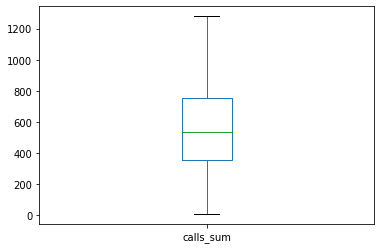

In [1684]:
# построим диаграмму размаха, чтобы оценить данные на наличие выбросов
calls_mean_ultra.plot.box()

В данных нет выбросов, теперь построим плотностную гистограмму.

Text(0.5, 1.0, 'Распределение минут тарифа "ультра"')

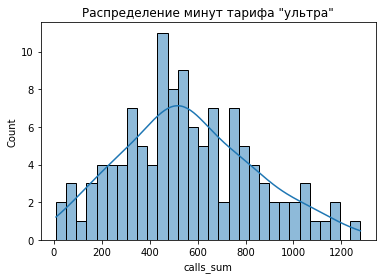

In [1685]:
sns.histplot(data = calls_mean_ultra, kde=True, bins=30).set_title('Распределение минут тарифа "ультра"')

Распределение стремится к нормальному, есть небольшая скошенность вправо, виден разброс данных.

In [1686]:
# числовое описание данных
calls_mean_ultra.describe()

count    118.000
mean     559.156
std      274.756
min        9.429
25%      354.933
50%      533.375
75%      752.788
max     1279.400
Name: calls_sum, dtype: float64

Среднее значение немного больше медианы, что подтверждает скошенность вправо.

Стандартное отклонение равно 275 - это очень большое отклонение, которое говорит о большом разбросе данных. Проверим распределение по правилу трёх сигм: укладываются ли 99% значений в заданный интервал.

In [1687]:
calls_mean_ultra.mean() - 3 * np.sqrt(np.var(calls_mean_ultra, ddof=1))

-265.1118441910594

In [1688]:
calls_mean_ultra.mean() + 3 * np.sqrt(np.var(calls_mean_ultra, ddof=1))

1383.4235832523748

По правилу трёх сигм значения должны укладываться в интервал от -265 до 1383. Реальные значения лежат от 9 до 1279 и попадают в этот интервал. Это значит, что для всех пользователей выборки достаточно иметь в пакете 1279 минут разговора.

В тариф "ультра" включено 3000 минут разговора, но, судя по полученным данным, никто не использует столько. В тарифе "смарт" 500 минут разговора - оценим примерное количество пользователей тарифа "ультра", которые используют менее 500 минут в месяц в среднем.

Text(0.5, 1.0, 'Распределение вероятностей для минут тарифа "ультра"')

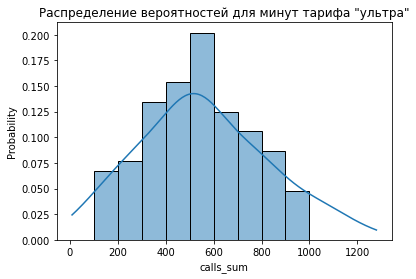

In [1689]:
# построим распределение вероятностей для каждого значения
sns.histplot(data = calls_mean_ultra, stat = "probability", kde=True, bins=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]).set_title('Распределение вероятностей для минут тарифа "ультра"')

In [1690]:
# посчитаем вероятность попасть в интервал до 500
mu = 559 # среднее значение распределения
sigma = 275 # стандартное отклонение распределения

x = 500 # интересующее значение

distr = st.norm(mu, sigma)
result = distr.cdf(x)
result

0.415060862234965

Вероятность пользователя уложиться в 500 минут в месяц, равна примерно 42%.

##### Вывод

**Описательная статистика количества израсходованных минут тарифа "ультра":**   
Среднее: 559 минут   
Медиана: 533 минут    
Стандартное отклонение: 268 минут    
    
Распределение стремится к нормальному, данные немного скошены вправо, большое стандартное отклонение.   
99% значений лежат в интервале до 1279 минут, что в 2 раза меньше 3000 минут, входящих в пакет.   
42% значений лежат в интервале до 500 минут.   
Наибольшая вероятность (20%) приходится на интервал 500-600 минут.

#### Количество израсходованных минут для тарифа "смарт"

In [1691]:
# посчитаем среднее количество израсходованных минут в месяц для каждого пользователя тарифа "смарт"
calls_mean_smart = users.query('tariff == "smart"')['calls_sum']

<AxesSubplot:>

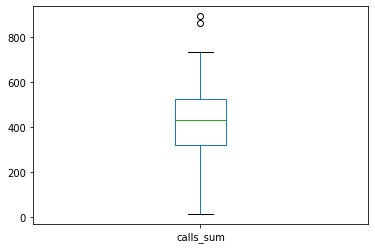

In [1692]:
# построим диаграмму размаха, чтобы оценить данные на наличие выбросов
calls_mean_smart.plot.box()

Обаружены единичные выбросы, необходимо их изучить дальше.

In [1693]:
# посмотрим на значения-выбросы
calls_mean_smart[calls_mean_smart > 800]

user_id
1041   861.000
1216   891.500
Name: calls_sum, dtype: float64

Text(0.5, 1.0, 'Распределение минут для тарифа "смарт"')

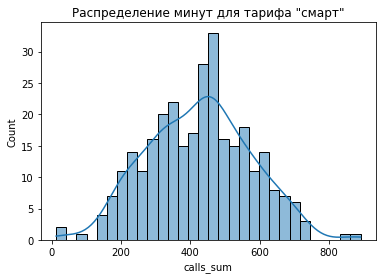

In [1694]:
# построим плотностную гистограмму распределения
sns.histplot(data = calls_mean_smart, kde=True, bins=30).set_title('Распределение минут для тарифа "смарт"')

Распределение стремится к нормальному, есть небольшая скошенность влево, разброс данных небольшой.

In [1695]:
# числовое описание данных
calls_mean_smart.describe()

count   301.000
mean    424.940
std     148.045
min      12.364
25%     318.250
50%     430.917
75%     525.667
max     891.500
Name: calls_sum, dtype: float64

Среднее значение почти совпадает с медианой, значит, выброс не оказывает существенного влияния на среднее.

Стандартное отклонение равно 148 минут - это в два раза меньше, чем было в тарифе "ультра", что говорит о меньшем разбросе данных. По правилу трёх сигм найдём интервал, в который входят 99% значений.

In [1696]:
calls_mean_smart.mean() - 3 * np.sqrt(np.var(calls_mean_smart, ddof=1))

-19.194232040112695

In [1697]:
calls_mean_smart.mean() + 3 * np.sqrt(np.var(calls_mean_smart, ddof=1))

869.074958143098

Таким образом, 99% пользователей укладываются до 869 минут в месяц в среднем. В тариф "смарт" включено 500 минут разговора, значит, нужно оценить количество пользователей тарифа, которые используют до 500 минут в месяц в среднем.

Text(0.5, 1.0, 'Распределение вероятностей для минут тарифа "смарт"')

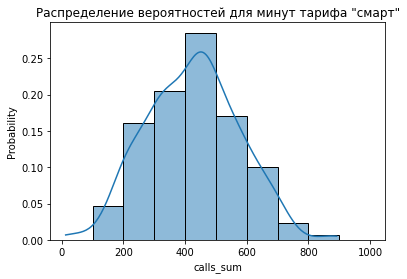

In [1698]:
# построим распределение вероятностей для каждого значения
sns.histplot(data = calls_mean_smart, stat = "probability", kde=True, bins=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]).set_title('Распределение вероятностей для минут тарифа "смарт"')

In [1699]:
# посчитаем вероятность попасть в интервал до 500
mu = 425
sigma = 148 # стандартное отклонение распределения

x = 500 # интересующее значение

distr = st.norm(mu, sigma)
result = distr.cdf(x)
result

0.6938372492396456

Вероятность попадания в интервал до 500 минут - 69%.

Text(0.5, 1.0, 'Распределение минут двух тарифов')

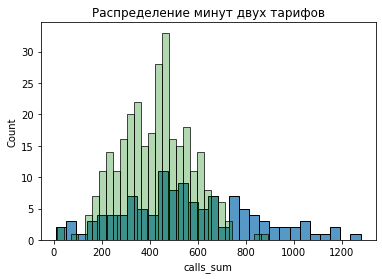

In [1700]:
# построим оба тарифа на одном графике для наглядности
ax = sns.histplot(data = calls_mean_ultra, bins=30)
sns.histplot(data = calls_mean_smart, bins=30, ax = ax, color='green', alpha=0.3).set_title('Распределение минут двух тарифов')

Пользователи тарифа "ультра" охватывают больший диапазон значений, но самое частое значение для обоих тарифов одинаково: около 500 минут.

##### Вывод

**Описательная статистика количества израсходованных минут тарифа "смарт":**   
Среднее: 425 минут   
Медиана: 431 минута    
Стандартное отклонение: 148 минут    
    
Распределение стремится к нормальному, данные немного скошены влево, стандартное отклонение в два раза меньше, чем у тарифа "ультра".   
99% значений лежат в интервале до 869 минут.   
69% значений лежат в интервале до 500 минут и укладываются в пакет.   
Наибольшая вероятность (30%) приходится на интервал 400-500 минут.    
     
Пользователи тарифа "ультра" охватывают больший диапазон значений, но самое частое значение для обоих тарифов одинаково: около 500 минут.

#### Количество израсходованных сообщений для тарифа "ультра"

In [1701]:
# посчитаем среднее количество израсходованных сообщений в месяц для каждого пользователя тарифа "ультра"
messages_mean_ultra = users.query('tariff == "ultra"')['messages_count']

<AxesSubplot:>

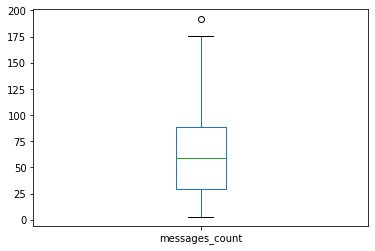

In [1702]:
# построим диаграмму размаха, чтобы оценить данные на наличие выбросов
messages_mean_ultra.plot.box()

Обнаружен единичный выброс, необходимо его изучить дальше.

In [1703]:
# посмотрим на значение-выброс
messages_mean_ultra[messages_mean_ultra > 175]

user_id
1028   192.000
1165   176.000
Name: messages_count, dtype: float64

192 сообщения - это выброс.

Text(0.5, 1.0, 'Распределение сообщений для тарифа "ультра"')

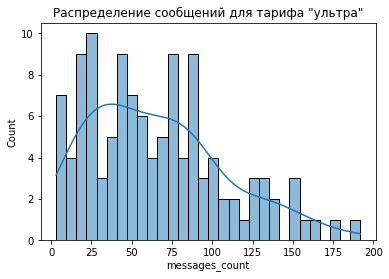

In [1704]:
# построим плотностную гистограмму распределения
sns.histplot(data = messages_mean_ultra, kde=True, bins=30).set_title('Распределение сообщений для тарифа "ультра"')

Данные сильно скошены вправо.

In [1705]:
# числовое описание данных
messages_mean_ultra.describe()

count   118.000
mean     65.419
std      42.411
min       3.000
25%      29.000
50%      59.167
75%      89.000
max     192.000
Name: messages_count, dtype: float64

Среднее отличается от медианы, но не радикально.

Стандартное отклонение равно 42 сообщения. По правилу трёх сигм найдём интервал, в который входят 99% значений.

In [1706]:
messages_mean_ultra.mean() - 3 * np.sqrt(np.var(messages_mean_ultra, ddof=1))

-61.81360008131324

In [1707]:
messages_mean_ultra.mean() + 3 * np.sqrt(np.var(messages_mean_ultra, ddof=1))

192.65158097988737

Таким образом, 99% пользователей укладываются до 193 сообщений в месяц в среднем (в этот интервал вошёл даже выброс). В тариф "ультра" включено 1000 сообщений - пользователям явно не нужно столько и они никогда не выходят за рамки пакета.

Text(0.5, 1.0, 'Распределение вероятностей для сообщений тарифа "ультра"')

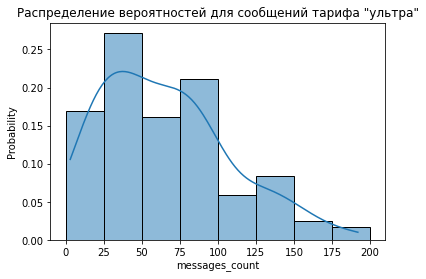

In [1708]:
# построим распределение вероятностей для каждого значения
sns.histplot(data = messages_mean_ultra, stat = "probability", kde=True, bins=[0, 25, 50, 75, 100, 125, 150, 175, 200]).set_title('Распределение вероятностей для сообщений тарифа "ультра"')

In [1709]:
# посчитаем вероятность попасть в интервал до 50
mu = 65 # среднее значение распределения
sigma = 42 # стандартное отклонение распределения

x = 50 # интересующее значение

distr = st.norm(mu, sigma)
result = distr.cdf(x)
result

0.3604924309508354

Вероятность попадания в интервал до 50 сообщений равна 36%.

Наибольшая вероятность 30% приходится на интервал 25-50 сообщений.

##### Вывод

**Описательная статистика количества израсходованных сообщений тарифа "ультра":**   
Среднее: 65 сообщений  
Медиана: 59 сообщений    
Стандартное отклонение: 42 сообщения      
    
Данные скошены влево, есть единичный выброс, но он входит в итервалы трёх сигм.   
99% значений лежат в интервале до 193 сообщений - это намного меньше количества сообщений в пакете.   
36% значений лежат в интервале до 50 сообщений.   
Наибольшая вероятность (30%) приходится на интервал 25-50 сообщений.

#### Количество израсходованных сообщений для тарифа "смарт"

In [1710]:
# посчитаем среднее количество израсходованных сообщений в месяц для каждого пользователя тарифа "смарт"
messages_mean_smart = users.query('tariff == "smart"')['messages_count']

<AxesSubplot:>

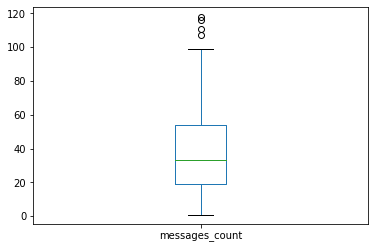

In [1711]:
# построим диаграмму размаха, чтобы оценить данные на наличие выбросов
messages_mean_smart.plot.box()

В данных есть несколько выбросов, необходимо их изучить дальше.

In [1712]:
# посмотрим на значения-выбросы
messages_mean_smart[messages_mean_smart > 100]

user_id
1112   107.000
1212   116.000
1324   118.000
1484   111.000
Name: messages_count, dtype: float64

4 выброса и все находятся недалеко друг от друга.

Text(0.5, 1.0, 'Распределение сообщений для тарифа "смарт"')

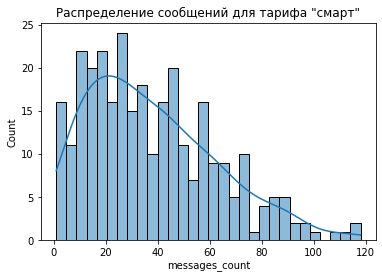

In [1713]:
# построим плотностную гистограмму распределения
sns.histplot(data = messages_mean_smart, kde=True, bins=30).set_title('Распределение сообщений для тарифа "смарт"')

Данные сильно скошены вправо.

In [1714]:
# числовое описание данных
messages_mean_smart.describe()

count   301.000
mean     37.640
std      24.876
min       1.000
25%      19.000
50%      33.000
75%      54.000
max     118.000
Name: messages_count, dtype: float64

Среднее отличается от медианы, но не радикально.

Стандартное отклонение равно 25 сообщений - это не очень много. По правилу трёх сигм найдём интервал, в который входят 99% значений.

In [1715]:
messages_mean_smart.mean() - 3 * np.sqrt(np.var(messages_mean_smart, ddof=1))

-36.98636969513106

In [1716]:
messages_mean_smart.mean() + 3 * np.sqrt(np.var(messages_mean_smart, ddof=1))

112.26704737846654

Таким образом, 99% пользователей укладываются до 112 сообщений в месяц в среднем (в интервал вошли два выброса). В тариф "смарт" включено 50 сообщений - нужно оценить, какое количество пользователей отправляют до 50 сообщений.

Text(0.5, 1.0, 'Распределение вероятностей для сообщений тарифа "смарт"')

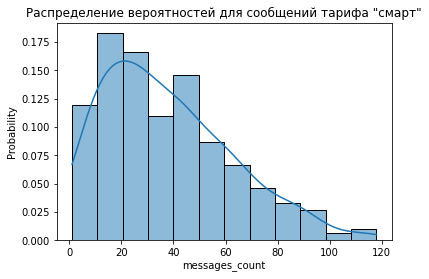

In [1717]:
# построим распределение вероятностей для каждого значения
sns.histplot(data = messages_mean_smart, stat = "probability", kde=True).set_title('Распределение вероятностей для сообщений тарифа "смарт"')

In [1718]:
# посчитаем вероятность попасть в интервал до 50
mu = 38 # среднее значение распределения
sigma = 25 # стандартное отклонение распределения

x = 50 # интересующее значение

distr = st.norm(mu, sigma)
result = distr.cdf(x)
result

0.6843863034837774

Вероятность того, что пользователь отправит в месяц до 50 сообщений, равно примерно 68%.   
Наибольший вероятностный интервал (18%) - 10-20 сообщений.

Text(0.5, 1.0, 'Распределение сообщений двух тарифов')

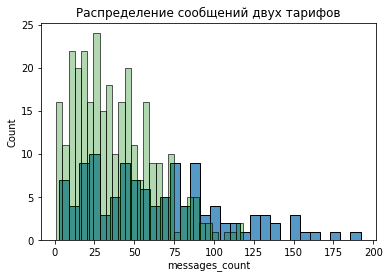

In [1719]:
# построим оба тарифа на одном графике для наглядности
ax = sns.histplot(data = messages_mean_ultra, bins=30)
sns.histplot(data = messages_mean_smart, bins=30, ax = ax, color='green', alpha=0.3).set_title('Распределение сообщений двух тарифов')

##### Вывод

**Описательная статистика количества израсходованных сообщений тарифа "смарт":**   
Среднее: 38 сообщений   
Медиана: 33 сообщения  
Стандартное отклонение: 25 сообщений      
    
Данные скошены вправо, есть 4 выброса, 2 из которых входят в интервалы трёх сигм.   
99% значений лежат в интервале до 112 сообщений.   
68% значений лежат в интервале до 50 сообщений.   
Наибольшая вероятность (18%) приходится на интервал 10-20 сообщений.

#### Объём израсходованного интернет-трафика для тарифа "ультра"

In [1720]:
# посчитаем среднее количество израсходованного интернет-трафика в месяц для каждого пользователя тарифа "ультра"
internet_mean_ultra = users.query('tariff == "ultra"')['gb_used']

<AxesSubplot:>

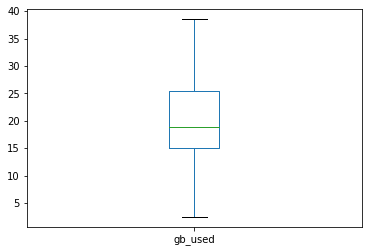

In [1721]:
# построим диаграмму размаха, чтобы оценить данные на наличие выбросов
internet_mean_ultra.plot.box()

Выбросов не обнаружено.

Text(0.5, 1.0, 'Распределение интернет-трафика для тарифа "ультра"')

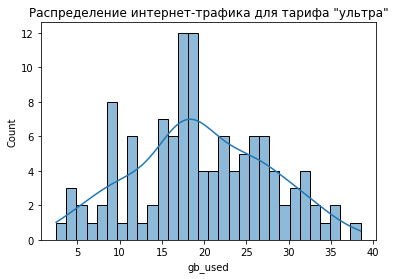

In [1722]:
# построим плотностную гистограмму распределения
sns.histplot(data = internet_mean_ultra, kde=True, bins=30).set_title('Распределение интернет-трафика для тарифа "ультра"')

Распределение стремится к нормальному, данные немного скошены вправо.

In [1723]:
# числовое описание данных
internet_mean_ultra.describe()

count   118.000
mean     19.593
std       7.875
min       2.500
25%      15.000
50%      18.837
75%      25.383
max      38.500
Name: gb_used, dtype: float64

Среднее немного больше медианы, как и должно быть при скошенности данных вправо.

Стандартное отклонение равно 8 гБ - это относительно немного. По правилу трёх сигм найдём интервал, в который входят 99% значений.

In [1724]:
internet_mean_ultra.mean() - 3 * np.sqrt(np.var(internet_mean_ultra, ddof=1))

-4.030921711518847

In [1725]:
internet_mean_ultra.mean() + 3 * np.sqrt(np.var(internet_mean_ultra, ddof=1))

43.21676073125617

Таким образом, 99% пользователей укладываются до 43 гБ в месяц в среднем, не все пользователи укладываются в 30 гБ, входящих в тариф. Теперь нужно оценить, какое количество пользователей отправляют расходуют до 30 гБ интернет-трафика.

Text(0.5, 1.0, 'Распределение вероятностей для интернет-трафика тарифа "ультра"')

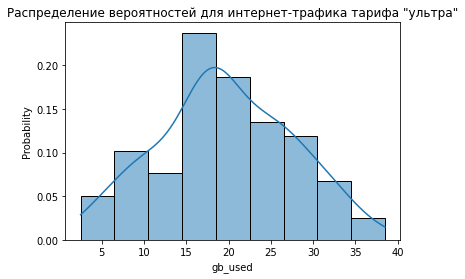

In [1726]:
# построим распределение вероятностей для каждого значения
sns.histplot(data = internet_mean_ultra, stat = "probability", kde=True).set_title('Распределение вероятностей для интернет-трафика тарифа "ультра"')

In [1727]:
# посчитаем вероятность попасть в интервал до 30 
mu = 20 # среднее значение распределения
sigma = 8 # стандартное отклонение распределения

x = 30 # интересующее значение

distr = st.norm(mu, sigma)
result = distr.cdf(x)
result

0.8943502263331446

Вероятность того, что пользователь использует в месяц до 30 гБ и уложится в пакет, равна примерно 89%.      
Наибольший вероятностный интервал (30%) - 15-20 гБ.

##### Вывод

**Описательная статистика объёма израсходованного интернет-трафика тарифа "ультра":**   
Среднее: 20 гБ    
Медиана: 19 гБ    
Стандартное отклонение: 8 гБ       
    
Данные немного скошены вправо, выбросов нет.   
99% значений лежат в интервале до 43 гБ.  
89% значений лежат в интервале до 30 гБ.   
Наибольшая вероятность (30%) приходится на интервал 15-20 гБ.

#### Объём израсходованного интернет-трафика для тарифа "смарт"

In [1728]:
# посчитаем среднее количество израсходованного интернет-трафика в месяц для каждого пользователя тарифа "смарт"
internet_mean_smart = users.query('tariff == "smart"')['gb_used']

<AxesSubplot:>

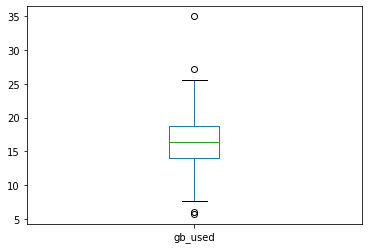

In [1729]:
# построим диаграмму размаха, чтобы оценить данные на наличие выбросов
internet_mean_smart.plot.box()

Выбросы есть в обе стороны, изучим их подробнее.

In [1730]:
# посмотрим на значения-выбросы
internet_mean_smart[internet_mean_smart > 25]

user_id
1159   35.000
1172   27.250
1441   25.500
Name: gb_used, dtype: float64

In [1731]:
internet_mean_smart[internet_mean_smart < 7]

user_id
1062   6.000
1285   5.727
Name: gb_used, dtype: float64

Выбросы лежат не сильно далеко от остального распределения.

Text(0.5, 1.0, 'Распределение интернет-трафика для тарифа "смарт"')

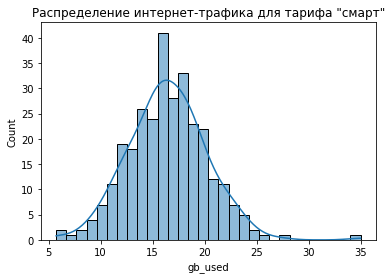

In [1732]:
# построим плотностную гистограмму распределения
sns.histplot(data = internet_mean_smart, kde=True, bins=30).set_title('Распределение интернет-трафика для тарифа "смарт"')

Распределение очень близко к нормальному.

In [1733]:
# числовое описание данных
internet_mean_smart.describe()

count   301.000
mean     16.460
std       3.776
min       5.727
25%      14.000
50%      16.333
75%      18.727
max      35.000
Name: gb_used, dtype: float64

Среднее практически совпадает с медианой, а значит, распределение максимально близко к нормальному и выбросы на него не влияют.

Стандартное отклонение равно 4 гБ - это очень небольшое отклонение. По правилу трёх сигм найдём интервал, в который входят 99% значений.

In [1734]:
internet_mean_smart.mean() - 3 * np.sqrt(np.var(internet_mean_smart, ddof=1))

5.132975708921952

In [1735]:
internet_mean_smart.mean() + 3 * np.sqrt(np.var(internet_mean_smart, ddof=1))

27.786192000445084

Таким образом, 99% пользователей укладываются до 28 гБ в месяц в среднем, не все пользователи укладываются в 15 гБ, входящих в тариф. Теперь нужно оценить, какое количество пользователей отправляют расходуют до 15 гБ интернет-трафика.

Text(0.5, 1.0, 'Распределение вероятностей для интернет-трафика тарифа "смарт"')

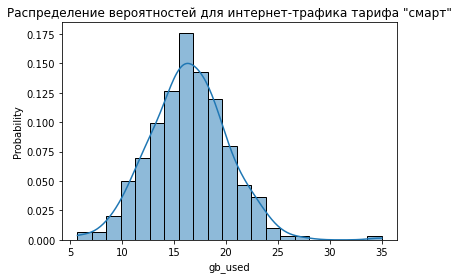

In [1736]:
# построим распределение вероятностей для каждого значения
sns.histplot(data = internet_mean_smart, stat = "probability", kde=True).set_title('Распределение вероятностей для интернет-трафика тарифа "смарт"')

In [1737]:
# посчитаем вероятность попасть в интервал до 15 гБ
mu = 16 # среднее значение распределения
sigma = 4 # стандартное отклонение распределения

x = 15 # интересующее значение

distr = st.norm(mu, sigma)
result = distr.cdf(x)
result

0.4012936743170763

Вероятность того, что пользователь использует в месяц до 15 гБ и уложится в пакет, равна примерно 40%.      
Наибольший вероятностный интервал (18%) - 15-16 гБ.

Text(0.5, 1.0, 'Распределение интернет-трафика двух тарифов')

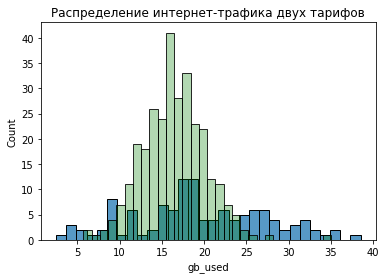

In [1738]:
# построим оба тарифа на одном графике для наглядности
ax = sns.histplot(data = internet_mean_ultra, bins=30)
sns.histplot(data = internet_mean_smart, bins=30, ax = ax, color='green', alpha=0.3).set_title('Распределение интернет-трафика двух тарифов')

##### Вывод

**Описательная статистика объёма израсходованного интернет-трафика тарифа "смарт":**   
Среднее: 16 гБ    
Медиана: 16 гБ     
Стандартное отклонение: 4 гБ       
    
Данные распределены нормально, есть небольшие выбросы в обе стороны.   
99% значений лежат в интервале до 28 гБ.  
40% значений лежат в интервале до 15 гБ.   
Наибольшая вероятность (18%) приходится на интервал 15-16 гБ.

In [1739]:
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_sum,gb_used,messages_count,revenue
user_id,,,,,,,,,,,
1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,320.750,13.625,62.000,1950.000
1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,216.714,16.714,10.000,1035.714
1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,764.400,11.800,76.000,1950.000
1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,123.375,18.750,149.000,1950.000
1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,550.417,8.583,46.000,827.000


In [1740]:
# посчитаем количество пользователей арифа "смарт", которые приносят выручку более 1950
users.query('tariff == "smart" and revenue > 1950')['revenue'].count()

47

### Проверка гипотез

#### Гипотеза 1

**Нулевая гипотеза**: средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.   
**Альтернативная гипотеза**: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.   
    
Это двусторонняя гипотеза, с помощью которой мы проверим, отличается ли средняя выручка от двух тарифов или нет. Если вероятность получить различные значения по выручке окажется слишком велика, чтобы быть случайностью, мы отвергаем нулевую гипотезу в пользу альтернативной.

Для проверки этой гипотезы нам понадобятся таблицы со средней выручкой отдельно по тарифам.

In [1741]:
ultra_revenue = users.query('tariff == "ultra"')['revenue']

In [1742]:
smart_revenue = users.query('tariff == "smart"')['revenue']

In [1743]:
# вычислим стандартную ошибку выборки тарифа "ультра"
s_u = np.std(ultra_revenue)
n_u = len(ultra_revenue)
ese_u = s_u / np.sqrt(n_u)
ese_u

25.0192555784938

In [1744]:
# вычислим стандартную ошибку выборки тарифа "смарт"
s_s = np.std(smart_revenue)
n_s = len(smart_revenue)
ese_s = s_s / np.sqrt(n_s)
ese_s

38.13102813211151

Text(0.5, 1.0, 'Распределение средней выручки тарифа "ультра"')

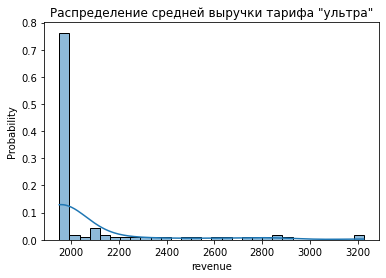

In [1745]:
# построим график распределения средней выручки тарифа "ультра"
sns.histplot(data = ultra_revenue, kde=True, bins=30, stat='probability').set_title('Распределение средней выручки тарифа "ультра"')

In [1746]:
ultra_revenue.describe()

count    118.000
mean    2066.660
std      272.938
min     1950.000
25%     1950.000
50%     1950.000
75%     1974.107
max     3225.000
Name: revenue, dtype: float64

На графике видно, что более 70% пользователей тарифа "ультра" не переплачивают сверх тарифа. 

Text(0.5, 1.0, 'Распределение средней выручки тарифа "смарт"')

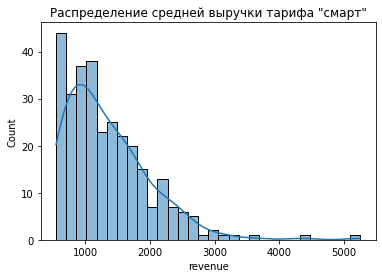

In [1747]:
# построим график распределения средней выручки тарифа "смарт"
sns.histplot(data = smart_revenue, kde=True, bins=30).set_title('Распределение средней выручки тарифа "смарт"')

In [1748]:
smart_revenue.describe()

count    301.000
mean    1339.890
std      662.650
min      550.000
25%      864.286
50%     1189.800
75%     1683.333
max     5252.000
Name: revenue, dtype: float64

Обе выборки не имеют нормального распределения. Это связано с тем, что они недостаточного размера. Чем больше выборка, тем больше она будет стремиться к нормальному распределению.   
   
Размеры выборок разные: у тарифа "ультра" 118 пользователей, а у тарифа "смарт" 301 пользователь. А так же есть основание предполагать, что дисперсии выборок не равны, и это нужно учесть при проведении статистического теста.

In [1749]:
# проведём статистический тест на равенство средних двух генеральных совокупностей
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    ultra_revenue, 
    smart_revenue,
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 8.371481258767274e-45
Отвергаем нулевую гипотезу


##### Вывод

Вероятность равенства средних выручек двух тарифов стремится к нулю, значит, нулевая гипотеза отвергается в пользу альтернативной.

#### Гипотеза 2

**Нулевая гипотеза**: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.   
**Альтернативная гипотеза**: средняя выручка пользователей из отличается от выручки пользователей из других регионов.   
    
Это двусторонняя гипотеза, с помощью которой мы проверим, отличается ли средняя выручка пользователей из Москвы от пользователей из других регионов или нет. Если вероятность получить различные значения выручки пользователей из и других регионов окажется слишком велика, чтобы быть случайностью, мы отвергаем нулевую гипотезу в пользу альтернативной.

In [1750]:
# получим выборку пользователей из Москвы
moscow_revenue = users.query('city == "Москва"')['revenue']

In [1751]:
# числовое описание moscow_revenue
moscow_revenue.describe()

count     82.000
mean    1522.788
std      656.685
min      550.000
25%      995.000
50%     1597.616
75%     1950.000
max     3233.000
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Распределение средней выручки для пользователей из Москвы')

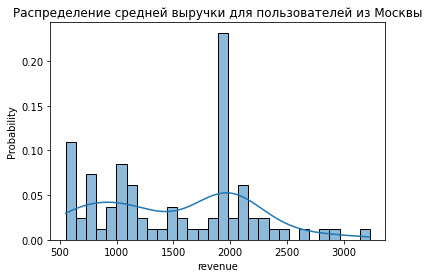

In [1752]:
# построим график распределения
sns.histplot(data=moscow_revenue, kde=True, stat='probability', bins=30).set_title('Распределение средней выручки для пользователей из Москвы')

In [1753]:
# получим выборку пользователей из других регионов
regions_revenue = users.query('city != "Москва"')['revenue']

In [1754]:
# числовое описание regions_revenue
regions_revenue.describe()

count    337.000
mean    1549.864
std      668.695
min      550.000
25%      983.600
50%     1570.600
75%     1950.000
max     5252.000
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Распределение средней выручки для пользователей из других регионов')

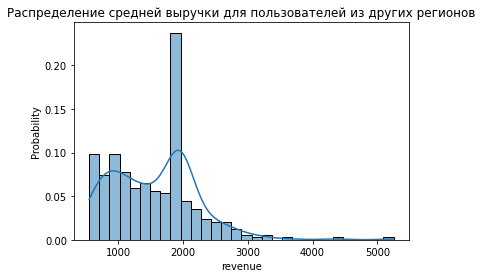

In [1755]:
# построим график распределения
sns.histplot(data=regions_revenue, kde=True, stat='probability', bins=30).set_title('Распределение средней выручки для пользователей из других регионов')

In [1756]:
# проведём статистический тест
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    moscow_revenue, 
    regions_revenue,
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.7392147507609139
Не получилось отвергнуть нулевую гипотезу


#####  Вывод

Таким образом, вероятность того, что выручка пользователей из Москвы и других регионов будет одинакова, очень велика - принимается нулевая гипотеза.

## Общий вывод

**Заказчик исследования:** Компания «Мегалайн» — федеральный оператор сотовой связи.   
**Описание проекта:** Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  
**Данные:** В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.   
**Задача:** Проанализировать тарифы и поведение клиентов, использующих их, и сделать вывод — какой тариф лучше.  
    
**РАЗДЕЛ 1. ИЗУЧЕНИЕ ДАННЫХ**   
   
У нас есть несколько датасетов с информацией о пользователях сотовой связи: users содержит справочную информацию о самом пользователе и тарифе, который он выбрал; calls, messages и internet содержат информацию об израсходованных минутах, сообщениях, интернет-траффике соответственно. А так же есть таблица tariffs с информацией о каждом тарифе. В нашем распоряжении информация о 500 пользователях, количество строк в данных со звонками, сообщениями и интернет-траффике везде разное. В датасете internet обнаружена и удалена лишняя колонка с дубликатами индексов `Unnamed: 0`.   
   
**РАЗДЕЛ 2. ПРЕДОБРАБОТКА ДАННЫХ**   
    
**2.1 Проверка типов данных**   
В этом разделе изучили все датасеты на типы данных: все даты привели к типу datetime, идентификационные номера - к целочисленному типу, количество минут тоже привели к целочисленному типу с округлением вверх.   
    
**2.2 Изучение пропусков**  
Пропуски есть только в churn_rate - это дата прекращения пользования тарифом. Если она пропущена, значит, тариф ещё действовал на момент выгрузки данных. Больше пропусков в данных нет.   
   
**2.3 Изучение значений по столбцам**  
- Идентификаторы пользователей в таблице представлены от 1000 до 1499.
- Возраст пользователей распределяется от 18 до 75 лет. Средний возраст - 46 лет.
- Длительность звонков распределяется от 0 минут (это пропущенные звонки) до 38 минут. Средняя длительность - 7 минут.
- Количество исрасходованных мБ интернет-трафика распределяется от 0 до 1725 мБ. Среднее значение - 370 мБ. Нулевые значения могут говорить о неудачных попытках выхода в интернет. Таких значений 13%, из них 11 - это тариф "смарт".    
   
**2.4 Подготовка данных**   
На этом этапе были посчитаны средние значения в месяц по минутам, сообщениям, трафику и выручке для каждого пользователя и добавлены в таблицу users.      
    
**РАЗДЕЛ 3. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ**
   
**3.1 Описательная статистика**    
     
*3.1.1 Количество израсходованных минут для тарифа "ультра"*   
    
Среднее: 559 минут   
Медиана: 533 минуты    
Стандартное отклонение: 268 минут    
    
Распределение стремится к нормальному, данные немного скошены вправо, большое стандартное отклонение.   
99% значений лежат в интервале до 1279 минут, что в 2 раза меньше 3000 минут, входящих в пакет.   
42% значений лежат в интервале до 500 минут.   
Наибольшая вероятность (20%) приходится на интервал 500-600 минут.   
   
*3.1.2 Количество израсходованных минут для тарифа "смарт"*   
     
Среднее: 425 минут   
Медиана: 431 минута    
Стандартное отклонение: 148 минут    
    
Распределение стремится к нормальному, данные немного скошены влево, стандартное отклонение в два раза меньше, чем у тарифа "ультра".   
99% значений лежат в интервале до 869 минут.   
69% значений лежат в интервале до 500 минут и укладываются в пакет.   
Наибольшая вероятность (30%) приходится на интервал 400-500 минут.   
    
*3.1.3 Количество израсходованных сообщений для тарифа "ультра"*   
      
Среднее: 65 сообщений  
Медиана: 59 сообщений    
Стандартное отклонение: 42 сообщения      
    
Данные скошены влево, есть единичный выброс, но он входит в итервалы трёх сигм.   
99% значений лежат в интервале до 193 сообщений - это намного меньше количества сообщений в пакете.   
36% значений лежат в интервале до 50 сообщений.   
Наибольшая вероятность (30%) приходится на интервал 25-50 сообщений.   
    
*3.1.4 Количество израсходованных сообщений для тарифа "смарт"*   
      
Среднее: 38 сообщений    
Медиана: 33 сообщения      
Стандартное отклонение: 25 сообщений      
    
Данные скошены вправо, есть 4 выброса, 2 из которых входят в интервалы трёх сигм.   
99% значений лежат в интервале до 112 сообщений.   
68% значений лежат в интервале до 50 сообщений.   
Наибольшая вероятность (18%) приходится на интервал 10-20 сообщений.   
    
*3.1.5 Объём израсходованного интернет-трафика для тарифа "ультра"*   
       
Среднее: 20 гБ    
Медиана: 19 гБ     
Стандартное отклонение: 8 гБ    
    
Данные немного скошены вправо, выбросов нет.   
99% значений лежат в интервале до 43 гБ.  
89% значений лежат в интервале до 30 гБ.   
Наибольшая вероятность (30%) приходится на интервал 15-20 гБ.   
    
*3.1.6 Объём израсходованного интернет-трафика для тарифа "смарт"*     
     
Среднее: 16 гБ    
Медиана: 16 гБ    
Стандартное отклонение: 4 гБ    
    
Данные распределены нормально, есть небольшие выбросы в обе стороны.   
99% значений лежат в интервале до 28 гБ.  
40% значений лежат в интервале до 15 гБ.   
Наибольшая вероятность (18%) приходится на интервал 15-16 гБ.   
    
**3.2 Проверка гипотез**   
*Гипотеза 1*   
Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.  
Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.  
   
Вероятность равенства средних выручек двух тарифов стремится к нулю, значит, нулевая гипотеза отвергается в пользу альтернативной.   
   
*Гипотеза 2*   
Нулевая гипотеза: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.
Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 
    
Вероятность того, что выручка пользователей из Москвы и других регионов будет одинакова, очень велика - принимается нулевая гипотеза.    
      
**ИТОГ**: тариф "ультра" выгоднее для компании, а "смарт" - для пользователей. Тариф "ультра" стоит дороже и приносит в среднем больше выручки, потому что все пользователи выборки переплачивают за ненужные минуты, сообщения и интернет, входящие в пакет, и никогда не успевают использовать его целиком. Всего лишь 47 пользователей тарифа "смарт" приносят выручку больше стоимости базового пакета "ультра" за 1950.